In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%config Completer.use_jedi = False

In [2]:
from datasets import InsectImgDataset
from utils import *
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A

from torchvision import datasets, transforms
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.utils import class_weight

setting = 'photobox'
if setting == 'photobox':
    ext = '.png'
elif setting == 'fuji':
    ext = '.jpg'

Available workers: 16


In [3]:
dfs = InsectImgDataset(ext=ext, setting=setting, directory=DATA_DIR)
dfs.extract_df_info()
df = dfs.df

Extracting info from filenames..: 100%|████████████████████████████████████████████████████████████████| 28363/28363 [00:03<00:00, 7810.50it/s]


# Creating train,val,test sets

## Removing outliers

In [4]:
df_pre = pd.read_parquet(f"{SAVE_DIR}/df_preparation_{setting}.parquet")
df = pd.merge(df,df_pre, on=['filename','label','platename','imgname','date','year','plate_idx','location','xtra'])
df = df[df.knn_outlier==0]
df = df[df.nb_contours>0]

oe = OrdinalEncoder(cols=['label'],mapping=[{'col':'label', 'mapping':{'bl':0,'wswl':1,'sp':2,'t':3,'sw':4,'k':5,'m':6,'c':7,'v':8,'wmv':9,'wrl':10}}])
df['txt_label'] = df['label']
df['label'] = oe.fit_transform(df.label)
df.head()

,filename,label,imgname,platename,year,location,date,xtra,plate_idx,blur,...,mean_cnt_area,mean_cnt_perimeter,std_cnt_area,std_cnt_perimeter,R,G,B,knn_outlier,knn_outlier_score,txt_label
0,/mnt/EE7455C074558BE9/backups/data_backups/ima...,0,2020_UNDISTORTED_herent_w28_1-90_4056x3040_202...,UNDISTORTED_herent_w28_1-90_4056x3040_20200703...,2020,herent,w28,1-90,11869,42.842744,...,116.875000,40.238329,132.378423,37.283882,205.431857,204.239418,210.109485,0,0.132859,bl
1,/mnt/EE7455C074558BE9/backups/data_backups/ima...,0,2020_herent_w27_1-30_4056x3040_23062020145640....,herent_w27_1-30_4056x3040_23062020145640.jpg,2020,herent,w27,1-30,25928,25.307896,...,60.870968,16.198733,835.417788,101.347855,133.678222,142.086978,129.338667,0,0.552473,bl
2,/mnt/EE7455C074558BE9/backups/data_backups/ima...,0,2020_herent_w27_1-30_4056x3040_23062020145640....,herent_w27_1-30_4056x3040_23062020145640.jpg,2020,herent,w27,1-30,25932,21.129386,...,54.502994,16.757472,555.751472,80.321145,136.486622,148.774933,143.012622,0,0.349623,bl
3,/mnt/EE7455C074558BE9/backups/data_backups/ima...,0,2020_herent_w27_1-30_4056x3040_23062020145640....,herent_w27_1-30_4056x3040_23062020145640.jpg,2020,herent,w27,1-30,25969,25.211150,...,31.208333,16.667472,155.566533,49.494496,146.883956,154.641333,143.112933,0,0.153815,bl
4,/mnt/EE7455C074558BE9/backups/data_backups/ima...,0,2020_herent_w27_1-30_4056x3040_23062020145640....,herent_w27_1-30_4056x3040_23062020145640.jpg,2020,herent,w27,1-30,25971,34.813996,...,46.980226,14.289273,555.609924,87.069623,137.986843,144.721766,132.789095,0,0.398847,bl


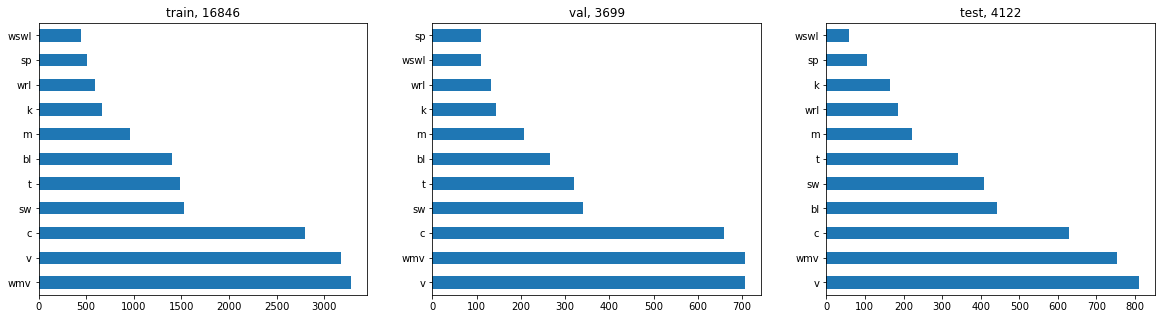

In [5]:
test_plates = train_test_split(df.platename.unique(), random_state=2022, test_size=0.2, shuffle=True)[1].tolist()
testseries = pd.Series(test_plates)
inds = testseries.apply(lambda x: 'wortel' in x)
inds = testseries[inds].sample(11).index.values
wortel_plates = testseries[inds].tolist()
test_plates = testseries[testseries.apply(lambda x: x.split('_')[1] != 'wortel')].tolist() + wortel_plates

df_trainval = df[~df.platename.isin(test_plates)]
df_test = df[df.platename.isin(test_plates)]

topclasses = df['label'].value_counts().head(11).index.tolist()

df = df[df['label'].isin(topclasses)]
df_trainval = df_trainval[df_trainval['label'].isin(topclasses)]
df_test = df_test[df_test['label'].isin(topclasses)]

class_weights = class_weight.compute_class_weight('balanced', 
                                                  classes=np.unique(df['label'].tolist()), 
                                                  y=df['label'].tolist())

class_weights = {np.unique(df['label'])[i]:class_weights[i] for i in range(len(class_weights))}
df['weights'] = df['label'].map(class_weights)

df_train, df_val = train_test_split(df_trainval, test_size=0.18, random_state=42, shuffle=True)


plt.figure(figsize=(20,5))
plt.subplot(1,3,1);df_train.txt_label.value_counts().plot(kind='barh');plt.title(f'train, {df_train.shape[0]}')
plt.subplot(1,3,2);df_val.txt_label.value_counts().plot(kind='barh');plt.title(f'val, {df_val.shape[0]}')
plt.subplot(1,3,3);df_test.txt_label.value_counts().plot(kind='barh');plt.title(f'test, {df_test.shape[0]}');

In [6]:
assert len(set(df_train.filename.tolist()).intersection(df_test.filename.tolist())) == 0
assert len(set(df_train.filename.tolist()).intersection(df_val.filename.tolist())) == 0

In [7]:
df_train.to_parquet(f"{SAVE_DIR}/df_train_{setting}.parquet")
df_val.to_parquet(f"{SAVE_DIR}/df_val_{setting}.parquet")
df_test.to_parquet(f"{SAVE_DIR}/df_test_{setting}.parquet")

In [8]:
df_train.label.value_counts()

9     3284
8     3175
7     2798
4     1526
3     1483
0     1402
6      962
5      665
10     597
2      505
1      449
Name: label, dtype: int64

# Creating Pytorch Datasets and Dataloaders

In [9]:
transforms_list_train = [
#     A.SmallestMaxSize(max_size=150),
#     A.Resize(height=150,width=150,p=1),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225], p=1, always_apply=True),
    A.ShiftScaleRotate(shift_limit=0.01,rotate_limit=45, scale_limit=0, p=.5),
    A.Rotate(limit=90, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    # A.RandomGamma(p=0.5),
     A.RandomBrightnessContrast(p=0.2),
     A.GaussianBlur(blur_limit=(3,3), p=0.1)
]

transforms_list_test = [
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225], 
                p=1, 
                always_apply=True)
]

train_dataset = InsectImgDataset(df=df_train.reset_index(drop=True), transform=A.Compose(transforms_list_train))
valid_dataset = InsectImgDataset(df=df_val.reset_index(drop=True), transform=A.Compose(transforms_list_test))
test_dataset = InsectImgDataset(df=df_test.reset_index(drop=True), transform=A.Compose(transforms_list_test))

batch_size = 32
batch_size_val = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

# plt.imshow(train_dataset[0][0]); plt.title(f"Example train image, class:{train_dataset[0][1]}");

# Defining the model and training parameters

In [10]:
torch.backends.cudnn.benchmark = True

In [11]:
modelname = "vgg19"
model = model_selector(modelname, pretrained=True)

if modelname.startswith("dense"):
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("resn"):
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("efficient"):
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("vgg"):
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, len(topclasses))
    
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

num_epochs = 40

class_sample_count = np.unique(df_train.label, return_counts=True)[1]
weight = 1. / class_sample_count  
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weight).cuda(), label_smoothing=.15)

Train on gpu: True


In [12]:
optimizer = optim.Adam(model.parameters(), lr=.001)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, cycle_momentum=False, mode="triangular2")

In [13]:
#optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3, amsgrad=True)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, cycle_momentum=False, mode="triangular2")

# Training

In [14]:
results = {"loss":[], "val_loss":[], "train_accuracy":[], "valid_accuracy":[]}
best_valacc = 0
# Model training
for epoch in range(num_epochs):
    # Going through the training set
    correct_train = 0
    model.train()
    for x_batch,y_batch,imgname,platename,filename,plate_idx,location,date,year,xtra,width,height in tqdm(train_dataloader, desc='Training..\t'):        
        y_batch = torch.as_tensor(y_batch)
        x_batch,y_batch = x_batch.float().cuda(), y_batch.cuda()
        for param in model.parameters():
            param.grad = None
        pred = model(x_batch)

        y_batch = y_batch.type(torch.LongTensor).cuda()
        correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
    train_accuracy = correct_train / len(train_dataset) * 100.
    torch.cuda.empty_cache()

    
    # Going through the validation set
    correct_valid = 0
    model.eval()
    with torch.no_grad():
        for x_batch,y_batch,imgname,platename,filename,plate_idx,location,date,year,xtra,width,height in tqdm(valid_dataloader, desc='Validating..\t'):
            y_batch = torch.as_tensor(y_batch)
            x_batch,y_batch = x_batch.float().cuda(), y_batch.cuda()
            pred = model(x_batch)

            y_batch = y_batch.type(torch.LongTensor).cuda()
            correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
            val_loss = criterion(pred, y_batch)
    valid_accuracy = correct_valid / len(valid_dataset) * 100.

    scheduler.step()


    # Printing results
    print(f"Epoch {epoch}: train_acc: {train_accuracy:.1f}% loss: {loss:.7f},  val_loss: {val_loss:.7f} val_acc: {valid_accuracy:.1f}%")
        
    is_best = valid_accuracy > best_valacc
    if is_best:
        print(f"Validation accuracy improved from {best_valacc:.2f} to {valid_accuracy:.2f}. Saving model..")
    best_valacc = max(valid_accuracy, best_valacc)
    save_checkpoint({
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'best_valacc': best_valacc,
        'loss': results['loss'].append(loss.detach().cpu()),
        'val_loss': results['val_loss'].append(val_loss.detach().cpu()),
        'train_accuracy': results['train_accuracy'].append(train_accuracy),
        'valid_accuracy': results['valid_accuracy'].append(valid_accuracy),
        'optimizer' : optimizer.state_dict(),
    }, is_best, f"{modelname}_{setting}")


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:08<00:00, 14.21it/s]


Epoch 0: train_acc: 51.3% loss: 1.9849348,  val_loss: 1.4883066 val_acc: 66.2%
Validation accuracy improved from 0.00 to 66.18. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.26it/s]


Epoch 1: train_acc: 65.2% loss: 1.5419004,  val_loss: 1.6327716 val_acc: 68.0%
Validation accuracy improved from 66.18 to 68.05. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.37it/s]


Epoch 2: train_acc: 69.9% loss: 1.2769473,  val_loss: 1.8022122 val_acc: 72.3%
Validation accuracy improved from 68.05 to 72.26. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.45it/s]


Epoch 3: train_acc: 72.8% loss: 1.5444527,  val_loss: 1.8638605 val_acc: 76.1%
Validation accuracy improved from 72.26 to 76.07. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [01:54<00:00,  1.01it/s]


Epoch 4: train_acc: 74.5% loss: 1.9911076,  val_loss: 1.3020315 val_acc: 75.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:11<00:00, 10.34it/s]


Epoch 5: train_acc: 75.1% loss: 1.3541598,  val_loss: 1.2696466 val_acc: 77.4%
Validation accuracy improved from 76.07 to 77.43. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.43it/s]


Epoch 6: train_acc: 75.5% loss: 1.9119077,  val_loss: 1.6381106 val_acc: 76.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.40it/s]


Epoch 7: train_acc: 76.5% loss: 2.4594264,  val_loss: 1.4457905 val_acc: 78.4%
Validation accuracy improved from 77.43 to 78.37. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.44it/s]


Epoch 8: train_acc: 77.4% loss: 1.1614540,  val_loss: 1.2842218 val_acc: 78.9%
Validation accuracy improved from 78.37 to 78.89. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.41it/s]


Epoch 9: train_acc: 77.5% loss: 1.7303791,  val_loss: 1.3705379 val_acc: 76.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.47it/s]


Epoch 10: train_acc: 78.0% loss: 1.5033057,  val_loss: 1.3561068 val_acc: 76.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.46it/s]


Epoch 11: train_acc: 78.5% loss: 1.2375011,  val_loss: 1.2968638 val_acc: 79.5%
Validation accuracy improved from 78.89 to 79.48. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.46it/s]


Epoch 12: train_acc: 78.9% loss: 1.1842856,  val_loss: 1.2687075 val_acc: 77.1%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.44it/s]


Epoch 13: train_acc: 78.2% loss: 1.8088849,  val_loss: 1.3712442 val_acc: 80.0%
Validation accuracy improved from 79.48 to 80.02. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.47it/s]


Epoch 14: train_acc: 78.9% loss: 1.4301217,  val_loss: 1.3516273 val_acc: 77.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.39it/s]


Epoch 15: train_acc: 77.9% loss: 0.9652441,  val_loss: 1.2754959 val_acc: 77.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.44it/s]


Epoch 16: train_acc: 79.2% loss: 1.9430428,  val_loss: 1.3478162 val_acc: 78.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.46it/s]


Epoch 17: train_acc: 79.4% loss: 1.3082550,  val_loss: 1.3347888 val_acc: 79.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.48it/s]


Epoch 18: train_acc: 79.8% loss: 1.4705634,  val_loss: 1.4377042 val_acc: 78.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.50it/s]


Epoch 19: train_acc: 79.8% loss: 1.3887761,  val_loss: 1.2865155 val_acc: 80.4%
Validation accuracy improved from 80.02 to 80.40. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.47it/s]


Epoch 20: train_acc: 78.7% loss: 0.9933304,  val_loss: 1.1985464 val_acc: 78.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.48it/s]


Epoch 21: train_acc: 79.5% loss: 2.2500606,  val_loss: 1.2299111 val_acc: 79.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.54it/s]


Epoch 22: train_acc: 79.7% loss: 1.7547407,  val_loss: 1.4182749 val_acc: 78.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.53it/s]


Epoch 23: train_acc: 79.0% loss: 1.3957316,  val_loss: 1.4435940 val_acc: 80.6%
Validation accuracy improved from 80.40 to 80.62. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.49it/s]


Epoch 24: train_acc: 79.3% loss: 1.1622320,  val_loss: 1.5298669 val_acc: 78.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.52it/s]


Epoch 25: train_acc: 80.3% loss: 1.2242184,  val_loss: 1.5536178 val_acc: 79.3%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.55it/s]


Epoch 26: train_acc: 80.1% loss: 0.9901829,  val_loss: 1.2322255 val_acc: 81.0%
Validation accuracy improved from 80.62 to 80.97. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.60it/s]


Epoch 27: train_acc: 79.1% loss: 1.2395096,  val_loss: 1.3123116 val_acc: 79.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.52it/s]


Epoch 28: train_acc: 79.1% loss: 1.2421407,  val_loss: 1.5921766 val_acc: 79.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.55it/s]


Epoch 29: train_acc: 80.2% loss: 1.1123899,  val_loss: 1.4518180 val_acc: 81.5%
Validation accuracy improved from 80.97 to 81.54. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.64it/s]


Epoch 30: train_acc: 80.5% loss: 1.4702556,  val_loss: 1.5240166 val_acc: 82.0%
Validation accuracy improved from 81.54 to 81.97. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.58it/s]


Epoch 31: train_acc: 79.4% loss: 1.6011167,  val_loss: 1.6580616 val_acc: 76.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.59it/s]


Epoch 32: train_acc: 79.0% loss: 1.0387098,  val_loss: 1.7032712 val_acc: 76.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.59it/s]


Epoch 33: train_acc: 79.7% loss: 1.2187583,  val_loss: 1.2680802 val_acc: 79.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.54it/s]


Epoch 34: train_acc: 80.1% loss: 1.2808022,  val_loss: 1.2814059 val_acc: 80.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.62it/s]


Epoch 35: train_acc: 79.1% loss: 1.2279747,  val_loss: 1.3379124 val_acc: 80.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.55it/s]


Epoch 36: train_acc: 79.4% loss: 1.2342086,  val_loss: 1.4472892 val_acc: 78.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.64it/s]


Epoch 37: train_acc: 79.6% loss: 1.7978057,  val_loss: 1.2669835 val_acc: 79.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.62it/s]


Epoch 38: train_acc: 79.5% loss: 1.1189500,  val_loss: 1.3091031 val_acc: 78.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.49it/s]


Epoch 39: train_acc: 79.1% loss: 1.9463062,  val_loss: 1.4322836 val_acc: 79.9%
